# Predicting Bankruptcies in Taiwan

In [1]:
#importing relevant libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_rows', 75)

In [3]:
def find_best_k_recall(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        recall = recall_score(y_test, preds)
        if recall > best_score:
            best_k = k
            best_score = recall
    
    print("Best Value for k: {}".format(best_k))
    print("Recall-Score: {}".format(best_score))

In [4]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [5]:
#bringing in file as pandas dataframe
df = pd.read_csv('data/taiwan_bankruptcy_data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,...,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


### Pre-Processing data

In [6]:
#checking info on entire dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Bankrupt?                                                            6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest             6819 non-null   float64
 2    ROA(A) before interest and % after tax                              6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax                   6819 non-null   float64
 4    operating gross margin                                              6819 non-null   float64
 5    realized sales gross margin                                         6819 non-null   float64
 6    operating profit rate                                               6819 non-null   float64
 7    tax P

Looking through the info method I see all my datatype are float or int so no need for extra cleaning there. Also no nan values for any variables so clean there as well

Columns I predict will be significant predictors:
    
    - interest expense ratio
    - interest-bearing debt interest rate
    - total debt/total net worth
    - long-term liability to current assets
    - cash flow to liability 
    - current liabilities to current assets
    - Degree of financial leverage (DFL)

In [7]:
#checking for unique values
for col in df.columns:
    print(col)
    print(df[col].value_counts(normalize = True, ascending=False).head(5))
    print("-------------------------------------------------------------")

Bankrupt?
0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64
-------------------------------------------------------------
 ROA(C) before interest and depreciation before interest
0.490128    0.001760
0.516453    0.001613
0.499196    0.001466
0.513821    0.001466
0.501926    0.001320
Name:  ROA(C) before interest and depreciation before interest, dtype: float64
-------------------------------------------------------------
 ROA(A) before interest and % after tax
0.568251    0.001906
0.559693    0.001906
0.554187    0.001466
0.563127    0.001466
0.558929    0.001466
Name:  ROA(A) before interest and % after tax, dtype: float64
-------------------------------------------------------------
 ROA(B) before interest and depreciation after tax
0.538787    0.001466
0.558220    0.001466
0.552492    0.001466
0.551475    0.001466
0.543445    0.001320
Name:  ROA(B) before interest and depreciation after tax, dtype: float64
-------------------------------------------------------------
 oper

0.028387    0.007919
0.026129    0.007039
0.021613    0.006746
0.026452    0.006599
0.024516    0.006453
Name:  net worth turnover rate (times), dtype: float64
-------------------------------------------------------------
 revenue per person
0.013610    0.000880
0.007597    0.000733
0.008681    0.000733
0.023794    0.000733
0.008155    0.000733
Name:  revenue per person, dtype: float64
-------------------------------------------------------------
 operating profit per person
0.394462    0.001906
0.392268    0.001613
0.393207    0.001613
0.394903    0.001613
0.395152    0.001613
Name:  operating profit per person, dtype: float64
-------------------------------------------------------------
 allocation rate per person
0.000000    0.000880
0.000521    0.000293
0.004960    0.000293
0.004832    0.000293
0.007482    0.000293
Name:  allocation rate per person, dtype: float64
-------------------------------------------------------------
 working capital to total assets
0.888684    0.000147
0.8

0    0.998827
1    0.001173
Name: one if total liabilities exceeds total assets zero otherwise, dtype: float64
-------------------------------------------------------------
net income to total assets
0.809910    0.000293
0.839891    0.000147
0.797847    0.000147
0.814917    0.000147
0.835167    0.000147
Name: net income to total assets, dtype: float64
-------------------------------------------------------------
total assets to GNP price
0.000539    0.000293
0.003661    0.000293
0.000745    0.000293
0.003997    0.000147
0.000377    0.000147
Name: total assets to GNP price, dtype: float64
-------------------------------------------------------------
No-credit interval
0.623892    0.000293
0.623816    0.000293
0.624019    0.000293
0.624104    0.000293
0.623928    0.000293
Name: No-credit interval, dtype: float64
-------------------------------------------------------------
Gross profit to Sales
0.665149    0.000587
0.608458    0.000293
0.601417    0.000147
0.625916    0.000147
0.611582  

In [8]:
## contingent liabilities of 

In [9]:
#checking predictors for multicollinearity

test = df.corr().abs().stack().reset_index().sort_values(0,ascending=False)
test['pairs'] = list(zip(test.level_0,test.level_1))
test.set_index(['pairs'], inplace=True)
test.drop(columns=['level_1','level_0'], inplace=True)
test.columns = ['cc']
test.drop_duplicates(inplace=True)
test.sort_values('cc',ascending=False, inplace=True)
multicollinear_predictors = test[test.cc >.75]
multicollinear_predictors.reset_index(inplace=True)

In [10]:
multicollinear_predictors['column_1'] = multicollinear_predictors.pairs.map(lambda x : x[0])
multicollinear_predictors['column_2'] = multicollinear_predictors.pairs.map(lambda x : x[1])

<ipython-input-10-a30768636eb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multicollinear_predictors['column_1'] = multicollinear_predictors.pairs.map(lambda x : x[0])
<ipython-input-10-a30768636eb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multicollinear_predictors['column_2'] = multicollinear_predictors.pairs.map(lambda x : x[1])


In [11]:
multicollinear_predictors

,pairs,cc,column_1,column_2
0,"( net worth/assets, debt ratio %)",1.000000,net worth/assets,debt ratio %
1,"( regular net profit growth rate, regular net...",1.000000,regular net profit growth rate,regular net profit growth rate
2,"(Gross profit to Sales, operating gross margin)",1.000000,Gross profit to Sales,operating gross margin
3,"( Net Value Per Share (C), Net Value Per Shar...",0.999837,Net Value Per Share (C),Net Value Per Share (A)
4,"( operating gross margin, realized sales gros...",0.999518,operating gross margin,realized sales gross margin
5,"( realized sales gross margin, Gross profit to...",0.999518,realized sales gross margin,Gross profit to Sales
6,"( Net Value Per Share (A), per Net Share Valu...",0.999342,Net Value Per Share (A),per Net Share Value (B)
7,"( per Net Share Value (B), Net Value Per Shar...",0.999179,per Net Share Value (B),Net Value Per Share (C)
8,"( Operating profit/paid-in capital, Operating...",0.998696,Operating profit/paid-in capital,Operating Profit Per Share (Yuan)
9,"( regular net profit growth rate, after-tax n...",0.996186,regular net profit growth rate,after-tax net profit growth rate


In [12]:
df.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' operating gross margin', ' realized sales gross margin',
       ' operating profit rate', ' tax Pre-net interest rate',
       ' after-tax net interest rate',
       ' non-industry income and expenditure/revenue',
       ' continuous interest rate (after tax)', ' operating expense rate',
       ' research and development expense rate', ' cash flow rate',
       ' interest-bearing debt interest rate', ' tax rate (A)',
       ' per Net Share Value (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan)',
       ' Operating Profit Per Share (Yuan)',
       ' Per Share Net profit before tax (yuan)',
       ' realized sales gross profit growth rate',
       ' operating profit growt

In [13]:
#Unsurprisingly, there are many columns that are correlated above .75 as my features
# are different line items on a financial statement
# below are chosen columns I think that models will still have accurate results without while
# still dealing with multicollinearity

columns_to_drop = [' net worth/assets','Gross profit to Sales',' Net Value Per Share (A)',' per Net Share Value (B)',
                  ' realized sales gross margin',' Operating profit/paid-in capital',' regular net profit growth rate',
                  ' continuous interest rate (after tax)',' ROA(A) before interest and % after tax',' ROA(B) before interest and depreciation after tax',
                  ' tax Pre-net interest rate',' net profit before tax/paid-in capital',
                  ' borrowing dependency',' Per Share Net profit before tax (yuan)',
                  'liability to equity',' Cash flow to Sales','operating funds to liability',' Operating Profit Per Share (Yuan)',
                  ' after-tax net interest rate','one if net income was negative for the last two year zero otherwise',' contingent liabilities/net worth','one if total liabilities exceeds total assets zero otherwise']

In [14]:
len(columns_to_drop)

22

In [15]:
pre_pro = df.drop(columns=columns_to_drop,axis=1)

In [16]:
# seperating out my target and predictors into X and y and training and test groups
X = pre_pro.drop(columns='Bankrupt?',axis=1)
y = pre_pro['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)


In [17]:
#checking for class imbalance which we clearly have with our data
#this will need to be accounted for by resmapling in some way
y.value_counts(normalize=True), y.value_counts()

(0    0.967737
 1    0.032263
 Name: Bankrupt?, dtype: float64,
 0    6599
 1     220
 Name: Bankrupt?, dtype: int64)

In [18]:
#making function to generate a panda df with relevant scores
def model_scores(y_true,y_pred,model_name):
    
    results = ({'Model':model_name,
                    'precision_score': precision_score(y_true,y_pred),
                    'recall_score': recall_score(y_true,y_pred),
                     'accuracy_score': accuracy_score(y_true,y_pred),
                     'f1_score':f1_score(y_true,y_pred)
                    })
    model_results = pd.DataFrame(data=results,index=[0])
    return model_results

In [19]:
#defining sigmoid function to scale my data from 0-1
def sigmoid(x):
    x = np.array(x)
    return 1/(1 + np.e**(-1*x))

In [20]:
#Using smote on my training data
#this will allow me to resample my training data and fit my model based on the resampled training data
# After doing so, when i predict based on my unchanged X_test values my class imbalance issues should not be as bad

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 
X_train_smote_sig = X_train_smote.apply(sigmoid)
X_test_sig = X_test.apply(sigmoid)

## Models

### Logistic Regression Model

AUC: 0.9121391034901493
[[1486  161]
 [  15   43]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1647
           1       0.21      0.74      0.33        58

    accuracy                           0.90      1705
   macro avg       0.60      0.82      0.64      1705
weighted avg       0.96      0.90      0.92      1705



C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


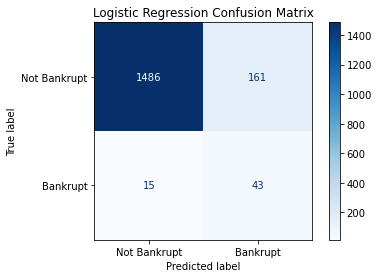

In [21]:
logreg = LogisticRegression(C=1e12,fit_intercept=True,solver='liblinear')
log_model = logreg.fit(X_train_smote_sig, y_train_smote)
y_hat_log = logreg.predict(X_test_sig)
y_score_log = log_model.decision_function(X_test_sig)
fpr,tpr,thresholds = roc_curve(y_test,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_log)

plot_confusion_matrix(log_model,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["Not Bankrupt", "Bankrupt"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test, y_hat_log))
print(classification_report(y_test, y_hat_log))

In [22]:
log_scores = model_scores(y_test,y_hat_log,'Logistic Regression')
log_scores

,Model,precision_score,recall_score,accuracy_score,f1_score
0,Logistic Regression,0.210784,0.741379,0.896774,0.328244


### Decision Tree Model

In [23]:
dtree = DecisionTreeClassifier(max_depth=12,min_samples_leaf=2,min_samples_split=9)

AUC: 0.7886072901618407
[[1547  100]
 [  21   37]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1647
           1       0.27      0.64      0.38        58

    accuracy                           0.93      1705
   macro avg       0.63      0.79      0.67      1705
weighted avg       0.96      0.93      0.94      1705



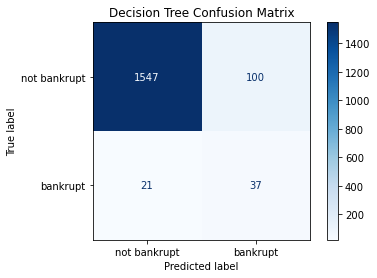

In [24]:
dtree.fit(X_train_smote_sig,y_train_smote)

y_pred_tree = dtree.predict(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_tree)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_tree)

plot_confusion_matrix(dtree,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("Decision Tree Confusion Matrix")

print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

In [25]:
dtree_scores = model_scores(y_test,y_pred_tree,"Decision Tree")
dtree_scores

,Model,precision_score,recall_score,accuracy_score,f1_score
0,Decision Tree,0.270073,0.637931,0.929032,0.379487


### Random Forest Model

In [26]:
forest = RandomForestClassifier(criterion='entropy',max_depth=6,min_samples_leaf=2,min_samples_split=5)

[[1510  137]
 [  12   46]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1647
           1       0.25      0.79      0.38        58

    accuracy                           0.91      1705
   macro avg       0.62      0.85      0.67      1705
weighted avg       0.97      0.91      0.93      1705



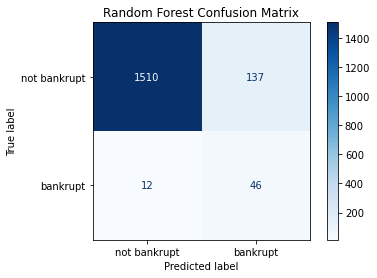

In [27]:
forest.fit(X_train_smote_sig,y_train_smote)

forest.predict(X_test_sig)

y_pred_forest = forest.predict(X_test_sig)

plot_confusion_matrix(forest,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")

plt.title("Random Forest Confusion Matrix")

print(confusion_matrix(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

After running our Random forest model through gridsearchcv to optimize our hyperparameters we were able to improve our model all around from our prior decision tree. For our 1 value of our bankruptcy class 'target variable', we improved recall by .05 to .62 and precision from .26 to .38. F1 score and accuracy were also improved as well

In [33]:
rf_scores = model_scores(y_test,y_pred_forest,"Random Forest")
rf_scores

,Model,precision_score,recall_score,accuracy_score,f1_score
0,Random Forest,0.251366,0.793103,0.91261,0.381743


### K-nearest Neighbors Model

AUC: 0.8178035299290245
[[1416  231]
 [  13   45]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1647
           1       0.16      0.78      0.27        58

    accuracy                           0.86      1705
   macro avg       0.58      0.82      0.60      1705
weighted avg       0.96      0.86      0.90      1705



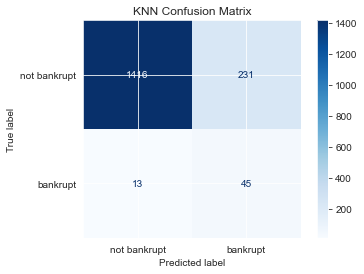

In [34]:
knn = KNeighborsClassifier(n_neighbors=13,p=1)
knn.fit(X_train_smote_sig,y_train_smote)
y_pred_knn = knn.predict(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_knn)

plot_confusion_matrix(knn,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("KNN Confusion Matrix")

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))



In [35]:
knn_scores = model_scores(y_test,y_pred_knn,'KNN')
knn_scores

,Model,precision_score,recall_score,accuracy_score,f1_score
0,KNN,0.163043,0.775862,0.856891,0.269461


### Gradient Boosted Model

In [36]:
grad_clf = GradientBoostingClassifier(learning_rate=.2,max_depth=1,
                                      min_samples_leaf=7,min_samples_split=1.0,n_estimators=100)

AUC: 0.8454295165714046
[[1507  140]
 [  13   45]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1647
           1       0.24      0.78      0.37        58

    accuracy                           0.91      1705
   macro avg       0.62      0.85      0.66      1705
weighted avg       0.97      0.91      0.93      1705



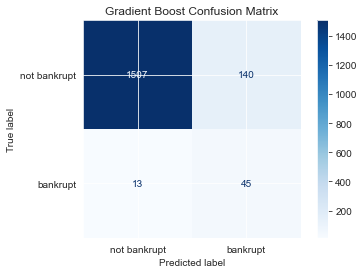

In [37]:
grad_clf.fit(X_train_smote_sig,y_train_smote)

y_pred_grad = grad_clf.predict(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_grad)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_grad)

plot_confusion_matrix(grad_clf,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("Gradient Boost Confusion Matrix")

print(confusion_matrix(y_test, y_pred_grad))
print(classification_report(y_test, y_pred_grad))

In [38]:
grad_scores = model_scores(y_test,y_pred_grad,"Gradient Boost")
grad_scores

,Model,precision_score,recall_score,accuracy_score,f1_score
0,Gradient Boost,0.243243,0.775862,0.910264,0.37037


### Adaboost Model

In [39]:
ada_clf = AdaBoostClassifier(base_estimator=forest)

AUC: 0.7933442204216652
[[1591   56]
 [  22   36]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1647
           1       0.39      0.62      0.48        58

    accuracy                           0.95      1705
   macro avg       0.69      0.79      0.73      1705
weighted avg       0.97      0.95      0.96      1705



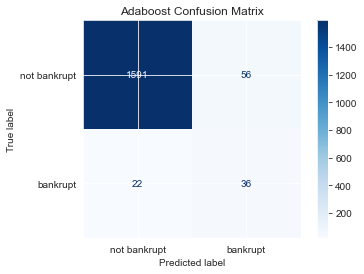

In [40]:
ada_clf.fit(X_train_smote_sig,y_train_smote)
y_pred_ada = ada_clf.predict(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_ada)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_ada)

plot_confusion_matrix(ada_clf,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("Adaboost Confusion Matrix")

print(confusion_matrix(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))


In [41]:
ada_scores = model_scores(y_test,y_pred_ada,"Adaboost")
ada_scores

,Model,precision_score,recall_score,accuracy_score,f1_score
0,Adaboost,0.391304,0.62069,0.954252,0.48


### XGBoost

In [42]:
XG = XGBClassifier(objective='binary:logistic',learning_rate=.05,max_depth=1,min_child_weight=1.5,
                   n_estimators=300,subsample=.75,tree_method='approx',gamma=1.5)

AUC: 0.870684420995331
[[1505  142]
 [  10   48]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1647
           1       0.25      0.83      0.39        58

    accuracy                           0.91      1705
   macro avg       0.62      0.87      0.67      1705
weighted avg       0.97      0.91      0.93      1705



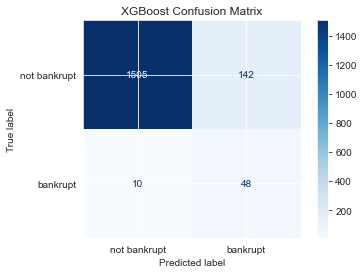

In [43]:
XG.fit(X_train_smote_sig,y_train_smote)
y_pred_XG = XG.predict(X_test_sig)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_XG)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_XG)

plot_confusion_matrix(XG,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("XGBoost Confusion Matrix")

print(confusion_matrix(y_test, y_pred_XG))
print(classification_report(y_test, y_pred_XG))


In [50]:
print(classification_report(y_test, y_pred_XG))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1647
           1       0.25      0.83      0.39        58

    accuracy                           0.91      1705
   macro avg       0.62      0.87      0.67      1705
weighted avg       0.97      0.91      0.93      1705



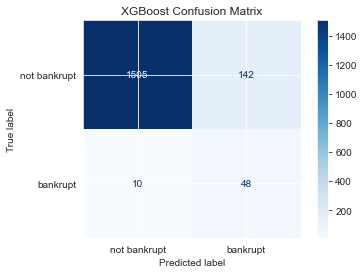

In [53]:
plot_confusion_matrix(XG,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("XGBoost Confusion Matrix")

plt.savefig('images/XGBoost_cm1.png')

In [55]:
XG_scores= model_scores(y_test,y_pred_XG,"XGBoost")
XG_scores

,Model,precision_score,recall_score,accuracy_score,f1_score
0,XGBoost,0.252632,0.827586,0.91085,0.387097


In [56]:
XG_features = pd.DataFrame(data = XG.feature_importances_, index=X.columns)

In [58]:
XG_features = XG_features.reset_index().rename(columns={'index': "features",0: 'feature_importance'})

In [59]:
XG_features.sort_values('feature_importance',ascending=False,inplace=True)

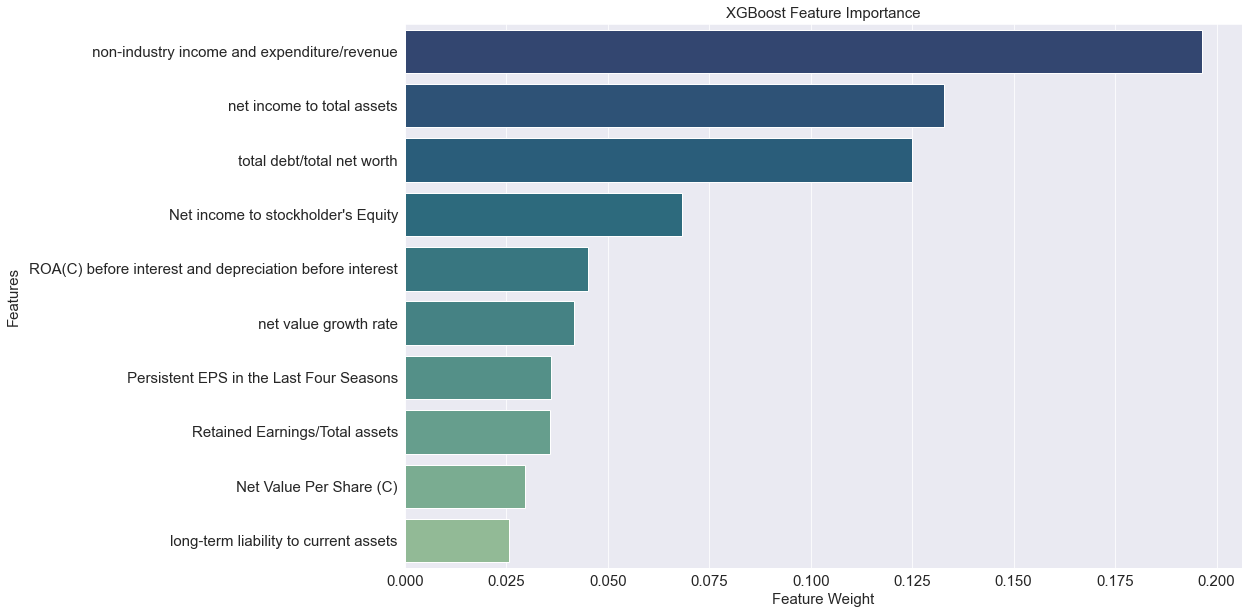

In [76]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=XG_features.head(10),y='features',x='feature_importance',palette='crest_r', ax=ax)
plt.title("XGBoost Feature Importance",size=15)
plt.ylabel("Features", size=15)
plt.xlabel("Feature Weight", size=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig('images/xgboost_features')

In [77]:
final_results = pd.DataFrame(data=None,index=[0])

In [78]:
final_results = pd.concat([log_scores,dtree_scores,rf_scores,knn_scores,grad_scores,ada_scores,XG_scores])

In [79]:
final_results = final_results.set_index('Model')

In [80]:
final_results

,precision_score,recall_score,accuracy_score,f1_score
Model,,,,
Logistic Regression,0.210784,0.741379,0.896774,0.328244
Decision Tree,0.270073,0.637931,0.929032,0.379487
Random Forest,0.251366,0.793103,0.912610,0.381743
KNN,0.163043,0.775862,0.856891,0.269461
Gradient Boost,0.243243,0.775862,0.910264,0.370370
Adaboost,0.391304,0.620690,0.954252,0.480000
XGBoost,0.252632,0.827586,0.910850,0.387097


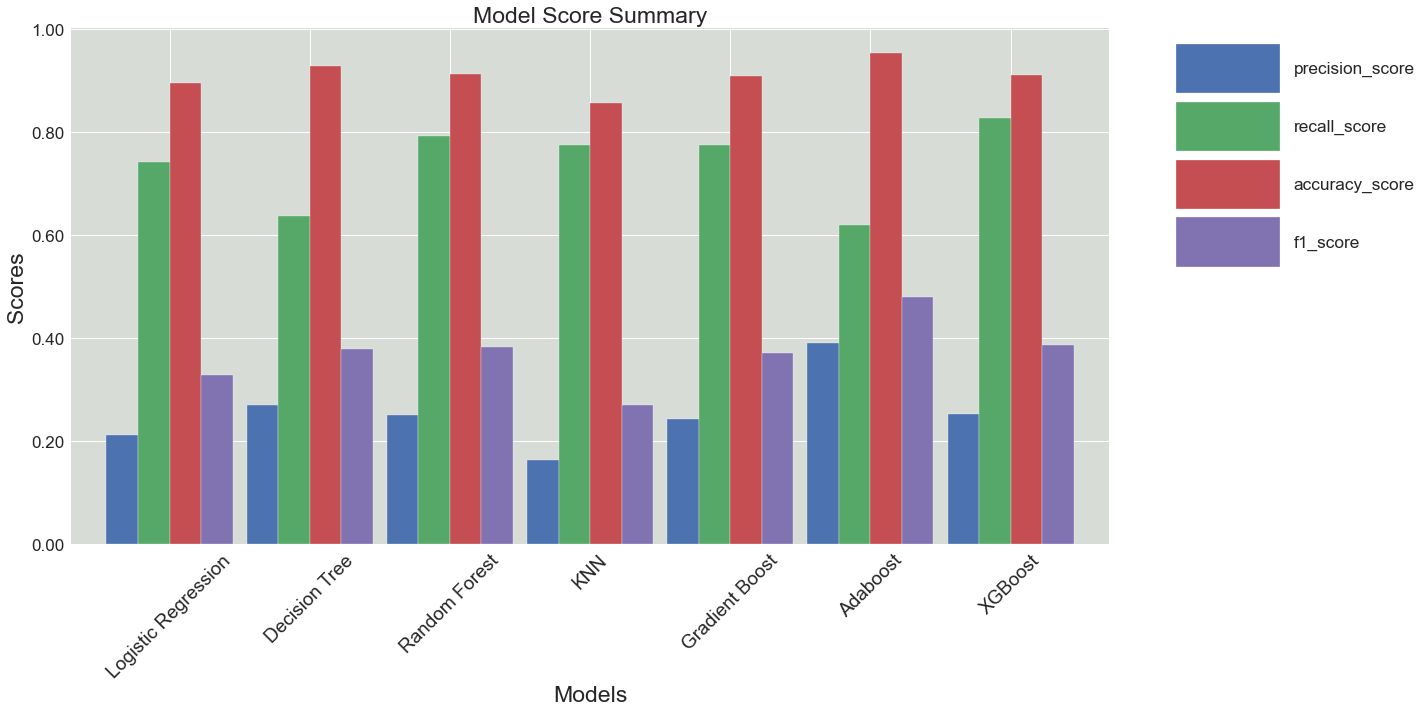

In [83]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

plt.style.use('seaborn')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_facecolor('#d8dcd6')
final_results.plot(kind='bar',figsize=(20,10), ax=ax,width=.9)
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=( 1.05,1),
          ncol=1, fancybox=True, shadow=True,handlelength=6, handleheight=4,fontsize="xx-large")
plt.title("Model Score Summary",size=23)
plt.ylabel('Scores',size=23)
plt.xlabel('Models',size=23)
plt.xticks(size = 19)
plt.yticks(size=17)
plt.tight_layout()
plt.savefig('images/model_summary_scores')